# 蒙特卡洛抽样方法以及应用

庞龙刚@华中师范大学

## 学习目标与内容

1. 回顾蒙特卡洛抽样的直接法与舍选法
2. 学习蒙特卡洛抽样的变换法
3. 马尔可夫链与随机行走
3. 马尔可夫链蒙特卡洛方法 MCMC
4. MCMC: Metropolis-Hastings 抽样
5. ** Gibbs 抽样
6. ** Hybrid Monte Carlo 抽样

In [1]:
# The python modules used in this notebook
import matplotlib.pyplot as plt
from IPython.display import IFrame
from IPython.display import Image
from scipy.integrate import simps
from scipy.stats import norm
import numpy as np

from tqdm import tqdm 

# 从 [0, 1] 区间的均匀分布抽样
from numpy.random import rand
# 从标准正态分布抽样
from numpy.random import randn

from ipywidgets import interact, widgets

plt.style.use(['science', 'notebook', 'no-latex'])

## 连续型随机变量的反函数法抽样
对于目标分布密度函数 $f(x)$ ，已知它的累积分布函数 cdf 为 

\begin{align}
F(x) = \int_{-\infty}^{x} f(t) dt
\end{align}

则可按以下步骤抽样 x，

1. 从均匀分布 U(0, 1) 中抽样 Y
2. 计算 $x = F^{-1}(Y)$。

In [2]:
def inverse_sampling_demo(n=10):
    x = np.linspace(-5, 5, 100)
    plt.plot(x, norm.cdf(x), color='k', label='cdf')
    # plot random Y
    Y = np.random.rand(n)
    xmin = norm.ppf(Y)
    plt.hlines(Y, xmin=xmin, xmax=5, alpha=0.1) 
    plt.hist(xmin, density=True, bins=20,
             color='r', alpha=0.5,
             label = 'pdf')
    
    xdash = np.array([-0.75, 0.75])
    plt.vlines(xdash, 
               ymin=0, ymax=norm.cdf(xdash), 
               linestyle='--',
               alpha=0.8)
    plt.legend(loc='best')

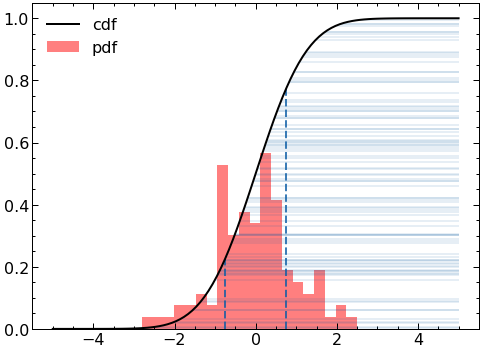

In [3]:
# 将 n 从 10 变到 50， 100， 1000 观察
inverse_sampling_demo(n=100) 

In [4]:
interact(inverse_sampling_demo, n=[10, 100, 1000])

interactive(children=(Dropdown(description='n', options=(10, 100, 1000), value=10), Output()), _dom_classes=('…

<function __main__.inverse_sampling_demo(n=10)>

**举例：指数分布**可用于描述粒子衰变寿命，粒子运动的平均自由程等。一般是 ${d f(t)\over dt} = -\lambda f(t)$ 的解，

它的分布密度函数 pdf 为，

\begin{align}
f(x) & = \lambda e^{-\lambda x},   \quad\; x>0, \lambda > 0 \\
\end{align}

它的累积概率分布 cdf 为，

\begin{align}
F(x) & = \int_{-\infty}^x f(t) dt = \int_0^x \lambda e^{-\lambda t} dt = 1 - e^{-\lambda x}
\end{align}

令 $Y \sim U(0, 1)$, 从 $ Y = F(x) =  1 - e^{-\lambda x}$ 可以反解出,

\begin{align}
x & = -{1 \over \lambda} \ln (1 - Y)
\end{align}

对于指数分布的反函数法抽样，

\begin{align}
x & = -{1 \over \lambda} \ln (1 - Y)
\end{align}

因为 $Y \sim U(0, 1)$, 所以 $1-Y \sim U(0, 1)$。

可以定义一个新的随机变量 $u = 1 - Y$, 直接抽样 $u  \sim U(0, 1)$, 对 x 的抽样可以简写为，

\begin{align}
x & = -{1 \over \lambda} \ln u
\end{align}

这个技巧也用在方位角 $p(\theta) = {\sin\theta \over 2}, \theta \in [0, \pi]$ 的抽样中。

练习 1： 使用 $x = - {1 \over \lambda} \ln u$ 抽取满足指数分布的 x, 画 histogram，并与指数分布的 pdf 对比。

练习 2： 如果指数分布的抽样区间不是 $(0, \infty)$, 而是 $[a, b]$, 如何用直接法抽样？

## 离散型随机变量的反函数法抽样

如果离散型随机变量 X 的取值为 $x_0, x_0, \cdots, x_{n-1}$, 

这些取值的概率分别为 $p_0, p_1, \cdots, p_{n-1}$, 且 $\sum_i p_i = 1$，

则它的累积概率分布是离散概率的部分求和，

\begin{align}
F(x) = \sum_{x_i \lt x} p_i
\end{align}

**直接抽样方法**： 抽样 $u\sim U(0, 1)$, 如果 $ \sum_{m=0}^{i-1} p_m < u < \sum_{m=0}^{i} p_m$, 则接受 $x = x_i$。

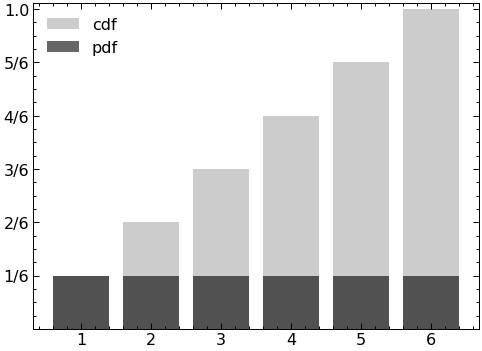

In [5]:
def discrete_inverse_sampling_demo(n=10):
    '''domo of a fair dice with equal probability for face-up'''
    x = np.linspace(1, 6, 6)
    y = np.ones_like(x)/6
    cdf = np.cumsum(y)
    plt.bar(x, cdf, color='k', alpha=0.2, label='cdf')
    plt.bar(x, y, color='k', alpha=0.6, label='pdf')
    plt.legend(loc='upper left')
    plt.yticks([i/6 for i in range(1, 7)],
              ['1/6', '2/6', '3/6', '4/6', '5/6', '1.0'])
    plt.ylim(0, 1.02)
    
discrete_inverse_sampling_demo()

**离散型随机变量应用举例**

$\gamma$ 光子与物质相互作用类型有三种：光电效应、康普顿散射和电子对效应，截面分别为 $\sigma_e, \sigma_s$ 和 $\sigma_p$，总散射截面为

\begin{align}
\sigma = \sigma_e + \sigma_s + \sigma_p
\end{align}

对光与物质的相互作用仿真可以使用如下方案：抽取随机数 $ u \sim U(0, 1)$,

(1) if $u < \sigma_e / \sigma$: 发生光电效应

(2) elif $u < (\sigma_e + \sigma_s) / \sigma$: 发生康普顿散射

(3) else: 发生电子对效应


python 中 elif 是 else if 的缩写。

**离散型随机变量应用举例**

**介质中有多种元素的散射**

$\gamma$ 光子或中子在介质中散射时，如果介质由多种元素组成，需要确定单次碰撞时碰撞核的种类。

假定中子或光子与每种核的碰撞截面分别为 $\sigma_1, \sigma_2, \cdots, \sigma_n$, 则它们与每种核碰撞的概率分别为， 
\begin{align}
p_i = {\sigma_i \over \sigma}, \quad\; i=1, 2, 3, \cdots
\end{align}

**中子与核反应类型的确定**

中子与核的反应粗分为弹性散射、非弹性散射、裂变、吸收几种，假设其反应截面分别为 $\sigma_{el}$,   $\sigma_{in}$,  $\sigma_{f}$,  $\sigma_{a}$, 可以用上面类似的方法抽样一次反应的核反应类型。

**离散型随机变量应用举例**


**$e^+ + e^- \rightarrow $ 2 喷注和 3 喷注**

\begin{align}
\sigma_{\rm 总} = \sigma_{\rm 2 喷注} + \sigma_{\rm 3 喷注}
\end{align}

**强子衰变通道**

很多强子会很快衰变到质量更轻、更稳定的粒子，它们的衰变通道往往有很多个，
概率由衰变分支比决定。

比如 $\Lambda^{0}(uds)$ 的衰变，几个主要衰变道如下，

\begin{align}
\Lambda & \xrightarrow{(63.9\pm 0.5)\%} p + \pi^{-} \\
\Lambda & \xrightarrow{(35.8\pm 0.5)\%} n + \pi^{0} \\
\Lambda & \xrightarrow{(1.75\pm 0.15)\times 10^{-3}} n + \gamma \\
\end{align}

计算末态稳定强子产额的时候，可以使用离散抽样决定共振态粒子的衰变通道。

**离散型随机变量应用举例**

泊松分布(Poisson distribution) 是**最重要的离散型**分布密度函数，它表示单位时间（或单位空间）内某事件发生 k 次的概率。

泊松分布的分布密度函数 pdf 为，

\begin{align}
p(X=k) = {\lambda^k \over k!} e^{-\lambda} \quad\; k=0, 1, 2, 3, \cdots
\end{align}

这个分布的唯一特征是 $\lambda$, 表示单位时间或空间内事件发生的平均次数。

In [6]:
def poisson(k, lam):
    return lam**k / np.math.factorial(k) * np.exp(-lam)

def poisson_dist_demo(lam):
    p = []
    klist = list(range(10))
    for k in klist:
        p.append(poisson(k, lam))

    plt.bar(klist, p, color='grey')
    plt.xlabel("k")
    plt.ylabel(r"$p(k, \lambda=%.2f)$"%lam)

interact(poisson_dist_demo, lam=[0.6, 1.0, 2.0, 5.0, 10])

interactive(children=(Dropdown(description='lam', options=(0.6, 1.0, 2.0, 5.0, 10), value=0.6), Output()), _do…

<function __main__.poisson_dist_demo(lam)>

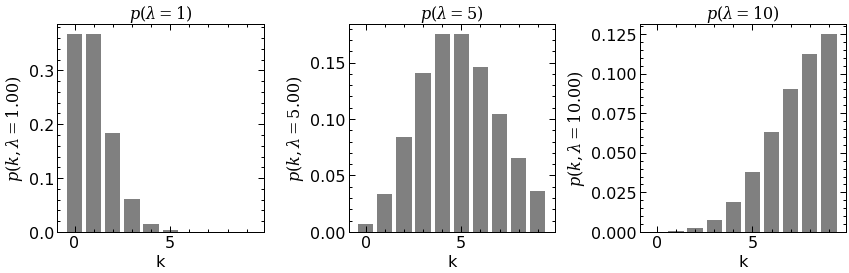

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title(r"$p(\lambda=1)$")
poisson_dist_demo(lam=1)
plt.subplot(132)
plt.title(r"$p(\lambda=5)$")
poisson_dist_demo(lam=5)
plt.subplot(133)
plt.title(r"$p(\lambda=10)$")
poisson_dist_demo(lam=10)
plt.tight_layout()

**泊松分布**有很多应用场景，

比如：一个快餐店每分钟平均客流量为 $1$ 人，

问两分钟内进来 1 位客人的概率是多少？

进来 2 位客人的概率是多少？ 

进来至少3位客人的概率是多少？

如何做一个蒙特卡洛仿真，模拟接下来两分钟的客流量？

In [8]:
po = lambda x: poisson(x, lam=2)

print("两分钟进来 1 位客人的概率是：", po(1))
print("进来 2 位客人的概率是：", po(2))

p_at_least_3 = 1 - po(0) - po(1) - po(2)
print("进来至少 3 位客人的概率是：", p_at_least_3)

两分钟进来 1 位客人的概率是： 0.2706705664732254
进来 2 位客人的概率是： 0.2706705664732254
进来至少 3 位客人的概率是： 0.3233235838169365


如果每分钟平均客流量为 1 人，模拟接下来两分钟的客流量，需要对泊松分布进行抽样。

两分钟平均客流量为 2 人，即 $\lambda = 2$, 我们要对 $x \sim poisson(\lambda = 2)$ 抽样。

因为泊松分布的随机变量为离散型随机变量，因此直接法抽样需要对不同的 k 计算累积概率，

\begin{align}
F(x) = \sum_{k<x} p(k)
\end{align}

k 可以从 0 到 $\infty$, 实际使用时 k 很大的时候概率几乎为 0，我们可以把概率分成 
$k=0, 1, 2, \cdots, n-1$ 名客人的概率以及进来至少 n 名客人的概率。

这样，离散的概率取值只有 n+1 个，且求和为 1。

Text(0, 0.5, 'num of customs')

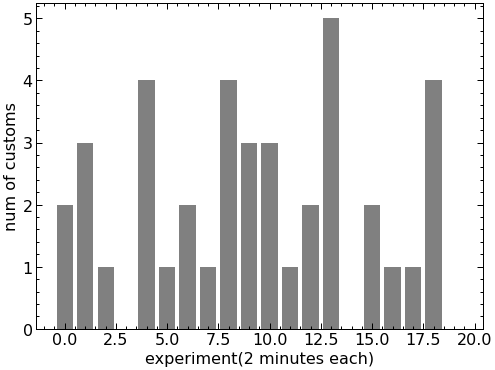

In [9]:
# 这里我们直接调用 np.random.poisson 函数进行抽样仿真
def sample_num_customs(n=1000, lam=2):
    custom_count = np.random.poisson(lam=lam, size=n)
    return custom_count

ncustom = sample_num_customs()

t = list(range(20))
plt.bar(t, ncustom[:20], color='grey')
plt.xlabel('experiment(2 minutes each)')
plt.ylabel('num of customs')

高能部分子穿过 QGP 时，在 $\Delta t$ 时间内与 QGP 中部分子发生碰撞的散射概率为 $\lambda = \Gamma \Delta t$, 假设 $\Delta t$ 很小，问 $\Delta t$ 时间内至少发生一次散射的概率为多少？

这是华师粒子所与劳伦斯伯克利国家实验室联合开发的 Linear Boltzmann Transport (LBT) model 里使用到的计算，

至少发生一次散射的概率等于泊松分布里发生 1 次散射的概率 $P(k=1)$ 加上发生 2 次散射的概率 $P(k=2)$, 再加上发生 3 次，4次一直到无穷次的概率。

这个概率不好算，但我们知道发生 $\sum_{k=0}^{\infty} P(k) = 1$。

所以至少发生 1 次的概率等于 1 减去泊松分布里发生 0 次散射的概率，

\begin{align}
1 - P(k=0) = 1 -  {\lambda^k \over k!} e^{-\lambda} |_{k=0} = 1 - e^{-\lambda} = 1 - e^{-\Gamma \Delta t}
\end{align}


另一个例子：QGP 火球表面穿过单位冷却超曲面的强子个数为 n, 已知一个很小的超曲面面积为 s，此面元穿过的平均强子个数 $\lambda = n s$ 非常小。我们要用蒙卡抽样得到这个面元出射的强子的信息，就要先使用泊松分布决定抽取几个强子，然后再给每个强子赋予 4 动量。详细流程：

1. 计算穿过此面元的平均强子个数 $\lambda$
2. 使用泊松分布抽取出射的强子个数 $m \sim p(\lambda)$
3. 如果 $m\ne0$, 则对 m 个强子赋予四动量 (下面是赋予 4 动量的步骤）
   - 先在 local rest frame 按玻色爱因斯坦或费米狄拉克分布抽样动量的绝对值 k
   - 按 $4 \pi$ 方位角均匀抽样动量的方向，得到四动量 $k^{\mu}$
   - 如果强子在流速为 $u^{\mu}$ 的流体中，还要对 $k^{\mu}$ 做洛伦兹 boost

根据泊松分布的定义，

\begin{align}
p(X=k) = {\lambda^k \over k!} e^{-\lambda} \quad\; k=0, 1, 2, 3, \cdots
\end{align}

可以证明，如果有 n 个随机变量，分别服从泊松分布 $p(\lambda_0), p(\lambda_1), \cdots, p(\lambda_{n-1})$ ，

将这 n 个随机变量的和定义成一个新的随机变量 K，则 K 仍服从泊松分布 $p(\lambda_t)$，其中 $\lambda_t = \lambda_0 + \lambda_1 + \cdots + \lambda_{n-1}$


- 如果单位体积中有多种强子，则可以先将它们的 $\lambda$ 求和，从泊松分布中抽样出总共需要产生的粒子数
- 对每个粒子，再按照不同强子的统计产额做离散分布抽样，确定强子的种类


## 2. 蒙特卡洛抽样的舍选法（Rejection Sampling）

**第一种方案**：如果已知 $f(x)$ 的最大值为 $y_{\rm max}$, 

欲对区间 [a, b] 上的分布密度函数 $f(x)$ 抽样，则可按如下步骤抽样 x，
```python
n = 0
while True:
    1. 按均匀分布 U(0, 1) 抽样 r1, 计算横坐标 x=a + (b-a)*r1 
    2. 按均匀分布 U(0, 1) 抽样 r2, 计算纵坐标 y= ymax * r2 
    3. 如果 y <= f(x), 则接受抽样。将成功抽样的样本数 n 增加 1。
    4. 如果 n 等于需要的样本数，break 停止 while 循环
```
下面是代码实现第一种舍选法的示意图。

In [10]:
def rejection_sampling_demo1(n=10, a=-5, b=5, ymax=0.4):
    x = np.linspace(a, b, 100)
    y = norm.pdf(x)
    plt.fill_between(x, 0, ymax, alpha=0.02)
    plt.vlines([a, b], ymin=0, ymax=ymax, alpha=0.2)
    plt.hlines(ymax, xmin=a, xmax=b, alpha=0.2)
    plt.plot(x, norm.pdf(x), 'k')
    
    xi = a + (b - a) * np.random.rand(n)
    yi = ymax * np.random.rand(n)
    below_f = yi < norm.pdf(xi)
    plt.scatter(xi[~below_f], yi[~below_f], 
                color='grey', alpha=0.2, label="reject")
    plt.scatter(xi[below_f], yi[below_f], 
                color='r', alpha=0.4, label='accept')
    plt.ylim(-0.02, 0.5)
    
    plt.legend(loc='best')
    plt.text(0, ymax+0.02, r'$y_{\rm max}$', size=20)

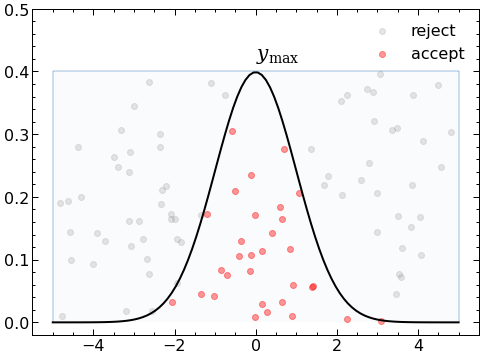

In [11]:
# 灰色点是被 ”舍弃 (reject)" 的点: ymax * r2 > f( a + (b-a)*r1 )

# 红色点是被 “接受 (accept)" 的点: ymax * r2 <= f( a + (b-a)*r1 )

# f(x) 越大的区域被 accept 的概率越大

rejection_sampling_demo1(n=100)

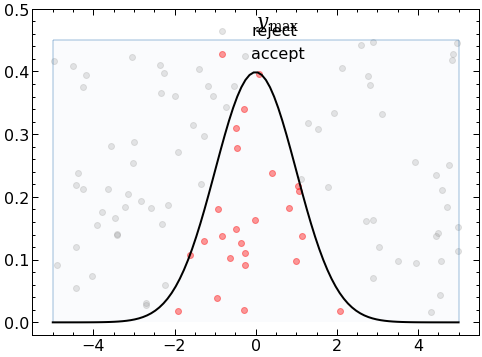

In [12]:
# 如果 f(x) 的分布比较尖，又有长尾
# ymax 选的远大于 f(x) 的最大值，都会有大量的点被 reject
rejection_sampling_demo1(n=100, ymax=0.45)

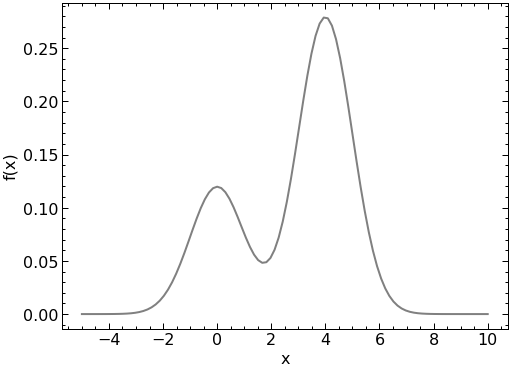

In [13]:
# 对下面这种 pdf, x ~ 0.3 N(0, 1) + 0.7 N(4, 1)，可以使用两个 box，覆盖不同的区域，减少 Rejection
# 或者先用离散型随机变量 z ~ [p1=0.3, p2=0.7] 决定是哪个分布，然后再用对应的正态分布抽样
def plot_hybrid_normal(shift=0):
    ''':shift: shift of the plot in the x direction'''
    norm1 = norm(loc=0+shift, scale=1).pdf
    norm2 = norm(loc=4+shift, scale=1).pdf
    f = lambda x: 0.3 * norm1(x) + 0.7 * norm2(x)
    x = np.linspace(-5+shift, 10+shift, 100)
    plt.plot(x, f(x), 'grey')
    plt.xlabel('x')
    plt.ylabel('f(x)')

plot_hybrid_normal()

(-0.02, 0.3)

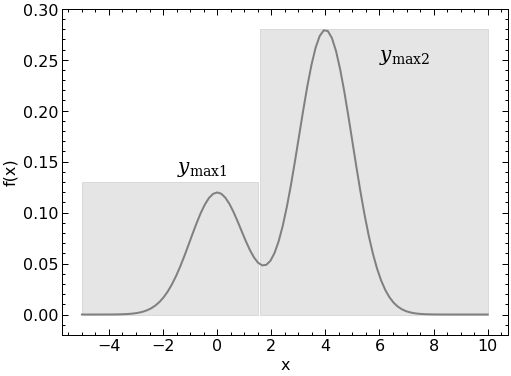

In [14]:
plot_hybrid_normal()

mid = 1.6
x1 = np.linspace(-5, mid-0.1, 100)
plt.fill_between(x1, np.ones_like(x1)*0.13, 
                 color='k', alpha=0.1)

x2 = np.linspace(mid, 10, 100)
plt.fill_between(x2, np.ones_like(x2)*0.28, 
                 color='k', alpha=0.1)

plt.text(-1.5, 0.14, r'$y_{\rm max1}$', size=20)
plt.text(6, 0.25, r'$y_{\rm max2}$', size=20)

plt.ylim(-0.02, 0.3)

**第二种方案**：如果已知一个容易抽样的分布密度函数 $g(x)$, 且在区间 [a, b] 上总是满足

\begin{align}
f(x) \le h \cdot g(x)
\end{align}

其中 $h$ 是一个常数，则可按如下步骤抽样 X～f(x)，

```python
n = 0
while True:
    1. 按 g(x) 抽样得到横坐标 x
    2. 按均匀分布 U(0, 1) 抽样 r2, 计算纵坐标 y = h * g(x) * r2 
    3. 如果 y <= f(x), 则接受抽样。将成功抽样的样本数 n 增加 1。
    4. 如果 n 等于需要的样本数，break 停止 while 循环
```
下面是代码实现第二种舍选法的示意图。

In [15]:
def rejection_sampling_demo2(n=10, a=-5, b=5):
    x = np.linspace(a, b, 100)
    y = norm.pdf(x)  
    g = lambda x: 0.5 * np.exp(-0.5*np.abs(x))
    plt.plot(x, g(x), 'k--', alpha=0.5, label='g(x)')
    # 画正态分布函数的 pdf
    plt.plot(x, norm.pdf(x), 'k', label='f(x)')
    # 对指数函数进行抽样，使用逆函数法 x = - 1/lambda * ln u
    rsign = -1 + 2 * np.random.rand(n)
    sign = np.where(rsign>0, 1, -1)
    xi = - 1/0.5 * np.log(np.random.rand(n)) * sign
    yi = g(xi) * np.random.rand(n)
    # 可视化被 reject 和 accept 的样本
    below_f = yi <= norm.pdf(xi)
    plt.scatter(xi[~below_f], yi[~below_f], 
                color='grey', alpha=0.2)
    
    plt.scatter(xi[below_f], yi[below_f], 
                color='r', alpha=0.4)
    
    plt.legend(loc='best')
    plt.ylim(-0.02, 0.5)
    plt.xlim(-5, 5)

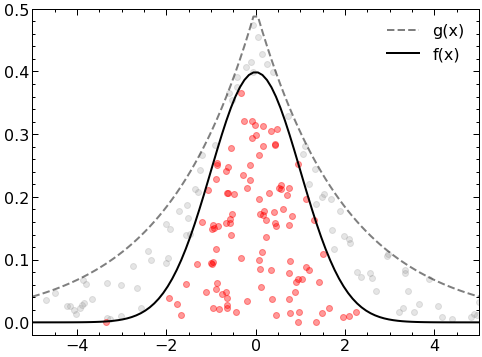

In [16]:
rejection_sampling_demo2(n=200)

思考：对于 $k^2 f(k)$ 这种分布密度函数，是否可以先用 $g(k)  = k^2/k_{\rm max}^3$ 抽样，然后对 $f(k)$ 用舍选法？

## 变换抽样法 

参考文献：(1) Flow-based Deep Generative Models
(2) 马文淦老师《计算物理》
(3) 丁泽军老师《计算物理》

为了理解**变换抽样法**，先回顾两个基本的数学概念，

1. 雅可比矩阵（Jacobian Matrix）和它的行列式(Determinant)
2. 变量变换法 (Change of variable theorem)

它们是多重微积分中的基本知识。

**雅可比矩阵（Jacobian matrix）和它的行列式**

如果有一个函数将 n 维向量 x 映射到 m 维向量 f，即 $f: R^n \rightarrow R^m$, 那么 f 对 x 的一阶导数项 $\partial f_i / \partial x_j$ 为雅可比矩阵 J 的矩阵元 $J_{ij}$，

\begin{align}
J = \begin{bmatrix} {\partial f_1 \over \partial x_1} & \cdots &{\partial f_1 \over \partial x_n} \\
\vdots & \cdots & \vdots \\
{\partial f_m \over \partial x_1} & \cdots &{\partial f_m \over \partial x_n}
\end{bmatrix}
\end{align}



**行列式（determinant）**是一个方阵所有矩阵元的函数，返回一个数字，这个数字表示线性变换对空间的缩放倍数。

\begin{align}
{\rm Det}\ J = \begin{vmatrix} {J_{11}} & \cdots &J_{1n} \\
\vdots & \cdots & \vdots \\
J_{n1} & \cdots & J_{nn}
\end{vmatrix} = \epsilon^{k_1 k_2 \cdots k_n} J_{1 k_1} J_{2 k_2} \cdots J_{n k_n}
\end{align}

注意矩阵用 $[\cdot]$ 或 $(\cdot)$ 表示，而行列式用 $|\cdot|$ 表示。上面最右边式子用到爱因斯坦求和公式（重复指标求和）。

只有 $f:R^n \rightarrow R^n$ 时，雅可比矩阵的行列式才可以计算。如果 ${\rm Det}\ J=0$, 映射不可逆。

**多变量微积分中的变量变换（Change of variable theorem）** 

有些问题经过变量变换会变得简单，比如半径为 R 的均匀分布的球，从内部抽取任何一点，使用 $x, y, z$ 坐标需要判断 $x^2 + y^2 + z^2 < R^2$, 使用球坐标则判断条件为 $r<R$, 独立于变量 $\theta$ 和 $\phi$。

几个随机变量互相独立，可以分别抽样：$p(r, \theta, \phi) = p(r) p(\theta) p(\phi)$。

在做球坐标到笛卡尔坐标的变量变换时，单位体积元在两个坐标下变换关系为，

\begin{align}
dx dy dz = r^2 \sin \theta\ dr d\theta d\phi = |J| dr d\theta d\phi
\end{align}

其中的 $r^2 \sin\theta$ 因子就来自于雅可比矩阵的行列式 |J|。

**练习**：
从 $(r, \theta, \phi)$ 到 $(x, y, z)$ 的变换为，
\begin{align}
x &= r \sin \theta \cos \phi \\
y &= r \sin \theta \sin \phi \\
z &= r \cos \theta
\end{align}

证明雅可比矩阵的行列式，


\begin{align}
|J| = \begin{vmatrix} {\partial x \over \partial r} & {\partial x \over \partial \theta} & {\partial x \over \partial \phi}  \\
 {\partial y \over \partial r} & {\partial y \over \partial \theta} & {\partial y \over \partial \phi}  \\
 {\partial z \over \partial r} & {\partial z \over \partial \theta} & {\partial z \over \partial \phi} 
\end{vmatrix} = r^2 \sin \theta 
\end{align}

**变换法抽样**

有些分布密度函数比较容易采样 $z \sim g(z)$，比如均匀分布 $z \sim U(0, 1)$ 。

对于复杂的分布密度函数 $f(x)$, 我们希望存在函数映射  $ T: z \rightarrow x$, 即 $x = T(z)$，使得 $x \sim f(x)$。

此映射应该保概率，$f(x) dx = g(z) dz$, 从而有，

\begin{align}
f(x) = \left|{\partial z \over \partial x} \right| g(z) = \left|{\partial T^{-1}(x) \over \partial x} \right| g(z)
\end{align}

(-6.5, 26.5, -0.013945178593423231, 0.2928488440304837)

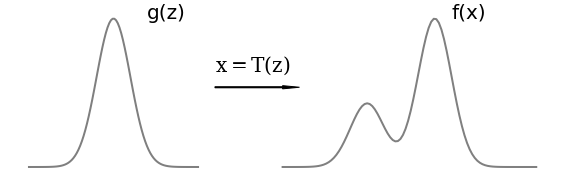

In [17]:
from matplotlib.patches import Arrow

plt.figure(figsize=(10, 3))
z = np.linspace(-5, 5, 100)
plt.plot(z, 0.7*norm.pdf(z), 'k', alpha=0.5)
plt.text(2, 0.28, 'g(z)', size=20)
arr = Arrow(6, 0.15, dx=5, dy=0, width=0.01, color="k")
plt.gca().add_patch(arr)
plt.text(6, 0.18, r'${\rm x = T(z)}$', size=20)
plot_hybrid_normal(shift=15)
plt.text(20, 0.28, 'f(x)', size=20)
plt.gca().axis('off')

举例：回顾3维球内部点的均匀采样，球坐标与笛卡尔坐标的变量转换，

1. 球坐标下概率密度分布对应上述示意图中的 $z\sim g(z)$， $z$ 为 $(r, \theta, \phi)$,

\begin{align}
p(r, \theta, \phi) = \left\{
\begin{array}{ll}
r^2 \sin\theta & {\rm for}\ r<R \\
0 & {\rm otherwise} \end{array} 
\right.
\end{align}

2. 笛卡尔坐标下概率密度分布对应上述示意图中$x \sim f(x)$, 为

\begin{align}
p(x, y, z) = \left\{
\begin{array}{ll}
1 & {\rm for}\ x^2 + y^2 + z^2<R^2 \\
0 & {\rm otherwise} \end{array} 
\right.
\end{align}

3. $(r, \theta, \phi)$ 到 $(x, y, z)$ 的变换对应函数映射 $T:z \rightarrow x$
\begin{align}
x &= r \sin \theta \cos \phi \\
y &= r \sin \theta \sin \phi \\
z &= r \cos \theta
\end{align}

举例：直接法（反函数法）抽样是变换抽样法的一个特例，此时

1. 容易抽样的分布密度为 $z \sim U(0, 1)$

2. 目标分布密度为 $f(x)$

3. z 到 x 的函数映射 $T:z\rightarrow x$ 为 cdf $F(x)$ 的反函数 $x = F^{-1}(z)$。

另一个之前使用到但未介绍的是正态分布的抽样，使用了线性变换和 Box-Muller 变换，

首先，任意均值为 $\mu$ 和 方差为 $\sigma^2$ 的正态分布 $\mathcal{N}(\mu, \sigma^2)$，可以通过线性变换，

\begin{align}
x = \mu + z \sigma
\end{align}

从标准正态分布 $z \sim \mathcal{N}(0, 1)$ 抽样的 $z$ 得到。

其次，标准正态分布 $z \sim  \mathcal{N}(0, 1)$ 可以使用 **Box-Muller 变换**得到，


\begin{align}
x & = \sqrt{-2 \ln u} \cos 2\pi v \\
y & = \sqrt{-2 \ln u} \sin 2\pi v 
\end{align}

其中 $u\sim U(0, 1)$, $v \sim U(0, 1)$，变换中的 $\sqrt{-2 \ln u}$ 表示极坐标下的半径，$2\pi v$ 表示极坐标下的角度。根据概率守恒，

\begin{align}
g(u, v) du dv & = p(x, y) dx dy = g(u, v) \begin{vmatrix} {\partial u \over \partial x} & {\partial u \over \partial y} \\
                    {\partial v \over \partial x} & {\partial v \over \partial y} \end{vmatrix} dxdy
\end{align}

根据反变换 
\begin{align}
 u &= \exp\left(- {x^2 + y^2 \over 2} \right) \\
 v &= {1 \over 2\pi} \arctan(y/x)
\end{align}

以及 $u, v$ 独立服从均匀分布，$g(u, v)=1$,可得，

\begin{align}
 p(x, y) = \begin{vmatrix} {\partial u \over \partial x} & {\partial u \over \partial y} \\
                    {\partial v \over \partial x} & {\partial v \over \partial y} \end{vmatrix} 
         = {1\over 2\pi} \exp\left(- {x^2 + y^2 \over 2} \right) = p(x) p(y)
\end{align}

这个算法可以同时得到两个独立的满足标准正态分布的随机变量的采样 $x\sim N(0, 1)$, $y\sim N(0, 1)$。

### 变换抽样法中如何寻找函数映射 $T:z\rightarrow x$ ?

从上面的 Box-Muller 算法知道，想得到目标函数的采样，从$z\rightarrow x$ 的函数映射可能很复杂。如何寻找这样的函数映射？

方法1，记住常用的变换抽样方法, 比如，

1. $z \sim U(0, 1)$ 到 $x \sim U(a, b)$ 的变换为 $x = a + z(b - a)$
2. $z \sim U(0, 1)$ 到 $ x \sim N(\mu, \sigma)$ 的变换为 $x = \mu + z * \sigma$
3. Box-Muller 变换从 $x, y \sim U(0, 1)$ 得到标准正态分布 $N(0, 1)$

方法2，构造可逆、双射的人工神经网络，实现 $z \rightarrow x$ 的映射，这是人工智能前沿流模型(Normalizng Flow)的主要思路。 

## 马尔科夫链蒙特卡洛 MCMC

如果被抽样函数高维、多变量，或者非归一化，此时传统的变换法抽样太复杂、舍选法抽样效率低下，就要用到一种新的抽样方法，称**马尔科夫链蒙特卡洛 （Markov Chain Monte Carlo，简称 MCMC）**。

MCMC 方法包括，

1. Metropolis-Hastings 算法
2. Gibbs 抽样
3. Hybrid Monte Carlo （广泛应用于 Lattice QCD）

### 什么是马尔可夫链 (Markov Chain)

A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

一个马尔可夫链是一个随机模型，描述序列发生的事件，序列中每个事件发生的概率只依赖于它的前一个事件的状态。

与马尔可夫链相反的一个例子是语言模型，一个语句出现的概率可以因式分解为一长串条件概率的乘积。

\begin{align}
P(x)=P\left(x_{0}\right) P\left(x_{1} | x_{0}\right) P\left(x_{2} | x_{0} x_{1}\right) \cdots P\left(x_{N} | x_{0} x_{1} x_{2} \cdots x_{N-1}\right)
\end{align}


比如 x = “My daughter loves WuHan” 这个语句在所有语句中出现的概率可表示成： 

\begin{align}
{\rm P(x)=P\left(My\right) P\left(daughter | My\right) P\left(loves | My\ daughter\right) P\left(WuHan | My\ daughter\ loves\right) }
\end{align}



如果假设每个字出现的概率只依赖于它的前一个字，就得到一个**马尔可夫链**，极大的简化了问题，

\begin{align}
{\rm P(x)=P\left(My\right) P\left(daughter | My\right) P\left(loves | daughter\right) P\left(WuHan | loves\right) }
\end{align}

### 为何 MCMC 算法都需要马尔可夫链

这是因为 MCMC 算法中样本都是按照序列产生的，互相之间不独立 (not indenpendent)。

下一个样本产生的时候，需要用到当前样本的信息。

对于分布密度函数 p(x), 它的样本是这样产生的 

\begin{align}
x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow x_3 \rightarrow \cdots 
\end{align}

其中 $x_0$ 是区间中随机选择的一个启动样本，下一个样本的产生需要**建议函数（proposal function）** $q(x_{i+1} | x_i)$。

**proposal function** 被用来实现样本空间的随机行走，它可以是很简单的以 $x_i$ 为中心的高斯函数，或小区间内的均匀分布密度函数。


## 随机行走 (Random Walk)

接下来我们使用一个简单的高斯函数作为 proposal function，做一些随机行走 (random walk) 测试。


\begin{align}
q(x_{i+1} | x_i) = \mathcal{N}(x_i, \sigma)
\end{align}

这个分布以当前样本 $x_i$ 为中心，以标准差为 $\sigma$ 的分布抽样，得到下一个样本 $x_{i+1}$。

$\sigma$ 是一个超参数，可以手动设置或动态调节。

此处可以看到，$x_{i+1}$ 依赖于 $x_i$ 的位置，因此被称为马尔可夫链。

In [18]:
def random_walk_with_proposal_function(x0=0, steps=1000, ntracks=1, sigma=0.1):
    '''random walk using proposal function
    :x0: starting point
    :steps: num of random walks
    :sigma: the std of the proposal normal distribution
    :return: make plot and return trajectories of ntracks (samples {xi})
    '''
    r = np.random.randn(steps, ntracks)
    # x is the history trajectory of the random walk
    x = [np.ones(ntracks) * x0]
    for i in tqdm(range(steps)):
        x1 = x[-1] + sigma * r[i]
        x.append(x1)
    
    x = np.array(x)
    for n in range(ntracks):
        plt.plot(x[:, n], color='r', alpha=0.2)
        
    plt.xlabel("steps")
    plt.ylabel(r"$x_i$")
    plt.title("%s random walk histories"%ntracks)
    return x

100%|██████████| 100000/100000 [00:00<00:00, 751880.28it/s]


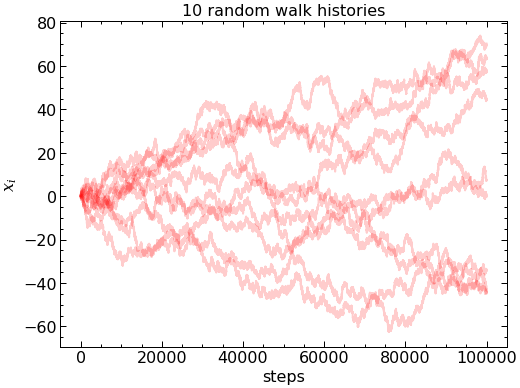

In [19]:
x = random_walk_with_proposal_function(steps=100000, ntracks=10)

In [20]:
## 绘制这 10 条随机行走路径轨迹 {xi} 的概率密度分布
ntracks = len(x[0, :])

def plot_xi_dist(trackid=0):
    _ = plt.hist(x[:, trackid], color='red', 
                 alpha=0.5, bins=20)
    
    plt.xlabel(r'sampled $x$')
    plt.ylabel("count")

interact(plot_xi_dist, trackid=range(ntracks))

interactive(children=(Dropdown(description='trackid', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output…

<function __main__.plot_xi_dist(trackid=0)>

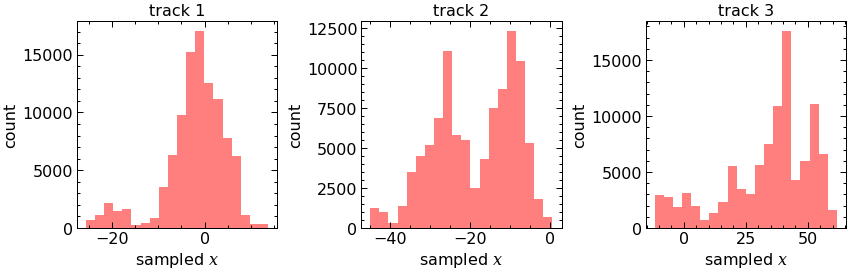

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("track 1")
plot_xi_dist(trackid=1)
plt.subplot(132)
plt.title("track 2")
plot_xi_dist(trackid=2)
plt.subplot(133)
plt.title("track 3")
plot_xi_dist(trackid=3)
plt.tight_layout()

## Metropolis Hastings 算法

仅仅是之前的随机行走，停留位置的集合 $\{x_i\}$ 还不满足要抽样的函数 $p(x)$。

只有使用 Hastings 算法，对停留位置的集合 $\{x_i\}$ 进行细致平衡条件过滤才行，

1. 从当前位置 $x_0$ 出发，使用 proposal function  $q(x_{1} | x_0)$ 抽取下一个样本 $x_{1}$

2. 计算 Hastings 判据，$\alpha = \min \left(1, {p(x_{1}) q(x_{0} | x_{1}) \over p(x_0) q(x_{1} | x_0)} \right)$

3. 按均匀分布抽取 $u \sim U(0, 1)$

4. 如果 $u \le \alpha$, 则 $X = x_{1}$； 否则，复制老的样本 $X = x_{0}$

Metroplis-Hastings 算法使用对称的 proposal function， Hastings 判据简化为 $\alpha = \min \left(1, {p(x_{i+1})  \over p(x_i) } \right)$, 换种理解方式，


1. 从当前位置 $x_0$ 出发，使用 proposal function  $q(x_{1} | x_0)$ 抽取下一个样本 $x_{1}$

2. 如果下一个样本处概率密度 $p(x_1)$ 大于 $p(x_0)$, 则 $\alpha=1$，百分百接受 $x_1$ 

3. 如果下一个样本处概率密度 $p(x_1)$ 小于 $p(x_0)$，也不用放弃，按照 $\alpha=p(x_1)/p(x_0)$ 的概率接受 $x_1$ 即可
   - 这需要我们按均匀分布抽取 $u \sim U(0, 1)$，如果 $u \le \alpha$, 接受 $x_1$; 如果 $u \gt \alpha$, 复制老的样本, 让 $X = x_0$

In [22]:
def metroplis_hastings(f, x0=0, steps=100000, ntracks=1, sigma=0.1):
    ''' M-H 算法，可以同时抽样多条轨迹 ntracks
    :f: pdf that we are going to sample
    :x0: starting point
    :steps: num of random walks
    :sigma: the std of the proposal normal distribution
    :return: make plot and return trajectories of ntracks (samples {xi})
    '''
    r = np.random.randn(steps, ntracks)
    # x is the history trajectory of the random walk
    x = [np.ones(ntracks) * x0]
    f0 = f(x[0])
    for i in tqdm(range(steps)):
        # 根据 proposal function 做随机行走
        x1 = x[-1] + sigma * r[i]
        f1 = f(x1)
        # 计算 Hasting 判据 alpha
        alpha = np.where(f(x1) > f(x0), 1, f(x1)/f(x0))
        u = np.random.rand(ntracks)
        # 按概率 alpha 接受新的样本，按 1-alpha 概率复制旧的样本
        X = np.where(u <= alpha, x1, x[-1])
        x.append(X)
        f0 = f1
    
    x = np.array(x)
    for n in range(ntracks):
        plt.plot(x[:, n], color='r', alpha=0.2)
        
    plt.xlabel("steps")
    plt.ylabel(r"$x_i$")
    plt.title("%s random walk histories"%ntracks)
    return x

100%|██████████| 100000/100000 [00:40<00:00, 2491.28it/s]


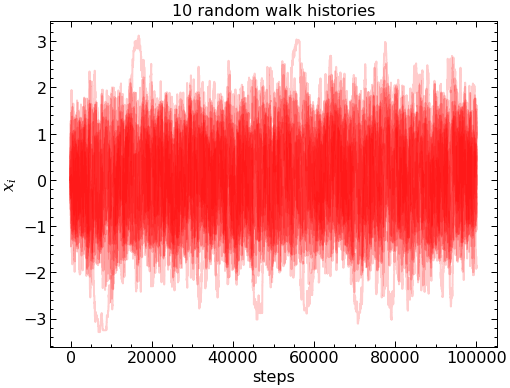

In [23]:
f = norm.pdf

xi = metroplis_hastings(f, ntracks=10)

In [24]:
ntracks = len(xi[0, :])

def plot_mh_dist(trackid=0):
    _ = plt.hist(xi[:, trackid], color='grey', 
                 alpha=0.5, bins=20,
                 density = True)
    xrange = np.linspace(-3, 3, 100)
    plt.plot(xrange, norm.pdf(xrange), 'r', alpha=0.5)
    
    plt.xlabel(r'sampled $x$')
    plt.ylabel("count")

interact(plot_mh_dist, trackid=range(ntracks))

interactive(children=(Dropdown(description='trackid', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output…

<function __main__.plot_mh_dist(trackid=0)>

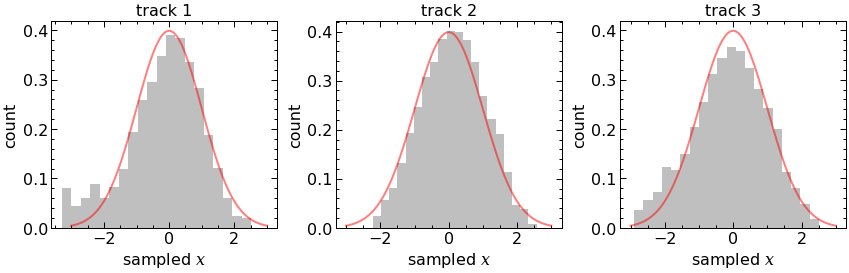

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("track 1")
plot_mh_dist(trackid=1)
plt.subplot(132)
plt.title("track 2")
plot_mh_dist(trackid=2)
plt.subplot(133)
plt.title("track 3")
plot_mh_dist(trackid=3)
plt.tight_layout()

## Gibbs 采样方法

对于高维目标分布 $p\left(X=(x_0, x_1, x_2, \cdots, x_m)\right)$, Gibbs 采样的目标是生成一组 m 维的样本 $\mathbf{x}^{(0)},\mathbf{x}^{(1)}, \cdots, \mathbf{x}^{(n)}$, 使得它们的分布满足 $p(\mathbf{x})$。

M-H 算法每一步更新所有的维度，有时接受率 $\alpha$ 非常小。

Gibbs 方法与 M-H 不同的地方在于，它的每步随机行走只选择一个维度。

比如，对于二维随机行走，pdf 为 $p(x, y)$, 如果当前的位置为 $(x^{(0)}, y^{(0)})$, 

则下一个时间步的采样步骤为，

\begin{align}
y^{(1)} \sim p(y^{(0)} | x^{(0)}) \\
x^{(1)} \sim p(x^{(0)} | y^{(1)})
\end{align}
此时 proposal function 为待采样函数的条件概率，每一步接受率 $\alpha=1$。

两步更新得到一个新的样本 $(x^{(1)}, y^{(1)})$，继续轮转迭代得到更多样本。

**何时使用 Gibbs 采样方法？**

举例：对于高维采样，比如 2 维，$x, y \sim p(x, y)$, 如果下面这些方法不行，

- 直接法
- 舍选法
- Metropolis-Hastings 算法

而被采样函数的条件概率容易计算，

- p(x | y) = p(x, y) / p(y)
- p(y | x) = p(x, y) / p(x)

则可以使用 Gibbs 采样方法

举例：从均值为 $\mu = (\mu_1, \mu_2)$, 协方差矩阵为

\begin{align}
\Sigma=\begin{bmatrix}\sigma_1^2 & \rho \\ \rho & \sigma_2^2 \end{bmatrix}
\end{align}
的二维正态分布中抽样。

注意：高维正态分布的分布密度函数为，

\begin{align}
\mathcal{N}_d(\mu, \Sigma) = {1 \over (2\pi)^{d/2} |\Sigma|^{1/2}}\exp\left[ -{1\over 2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right]
\end{align}

需要计算协方差矩阵的行列式(determinant) $|\Sigma|$ 以及它的逆矩阵 $\Sigma^{-1}$。

In [26]:
from numpy.linalg import det, inv

def normal2d_distribution_demo(x, y, rho=0.5):
    '''简单的 2 维正态分布示例
    x, y: 二维坐标点
    均值取： mu = (0, 0)
    协方差矩阵取：[[1, rho],
                  [rho, 1])
    '''
    tmp = - 0.5 *(x**2 + y**2 - 2*rho*x*y) / (1 - rho*rho)
    coef = 1 / (2 * np.pi * (1 - rho**2)**0.5)
    return coef * np.exp(tmp)

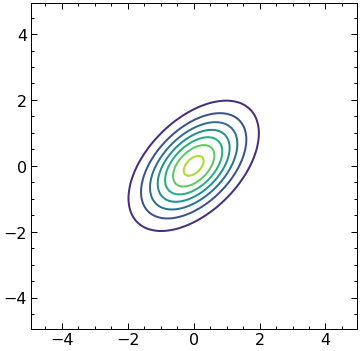

In [27]:
# 均值 mu=(0, 0), 协方差 Sigma=[[1, rho], [rho, 1]]
def plot_norm2d(rho=0.5):
    ngrid = 100
    x = np.linspace(-5, 5, ngrid)
    y = np.linspace(-5, 5, ngrid)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    norm2d = normal2d_distribution_demo(xx, yy, rho=rho)
    norm2d = norm2d.reshape(ngrid, ngrid)

    extent = [-5, 5, -5, 5]
    plt.contour(norm2d.T, 
               extent=extent,
               origin='lower')
    
    plt.gca().set_aspect('equal')

plot_norm2d()

对于 $\mu=(0, 0)$, $\Sigma = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}$ 的 2 维正态分布，

两个条件概率为，

\begin{align}
x | y &\sim \mathcal{N}(\rho y, 1-\rho^2) \\
y | x &\sim \mathcal{N}(\rho x, 1-\rho^2) \\
\end{align}

接下来使用这两个条件概率，做 Gibbs 采样

In [28]:
def gibbs_sampling(steps=10000, dims=2, rho = 0.5):
    r1 = np.random.randn(steps)
    r2 = np.random.randn(steps)
    std = np.sqrt(1 - rho*rho)
    x0, y0 = -3, 3
    x = [[x0, y0]]
    history = [[x0, y0]]
    for step in range(steps):
        y0 = x[-1][1]
        x1 = rho * y0 + r1[step] * std
        history.append([x1, y0])
        y1 = rho * x1 + r2[step] * std
        x.append([x1, y1])
        history.append([x1, y1])
    
    return np.array(x), np.array(history)

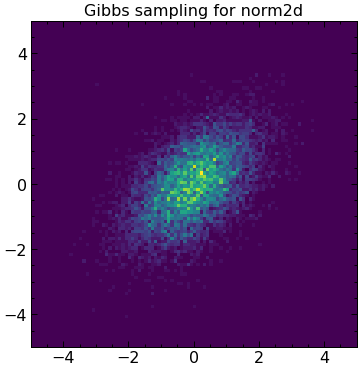

In [29]:
xy_norm, history = gibbs_sampling()
extent = [[-5, 5], [-5, 5]]
_ = plt.hist2d(xy_norm[:, 0], 
               xy_norm[:, 1],
               range=extent,
               bins = 100,
               cmap = 'viridis')
plt.title("Gibbs sampling for norm2d")

plt.gca().set_aspect('equal')

In [30]:
## Gibbs 采样的过程
def gibbs_sampling_demo(steps=2):
    plot_norm2d()
    x = history[:, 0]
    y = history[:, 1]
    
    for i in range(steps):
        if i%2 == 0: # 偶数步， x|y, 画横线
            xmin, xmax = np.sort([x[i], x[i+1]])
            plt.hlines(y[i], xmin=xmin, xmax=xmax, color='k')
        else:
            ymin, ymax = np.sort([y[i], y[i+1]])
            plt.vlines(x[i], ymin=ymin, ymax=ymax, color='k')  
        plt.scatter(x[:steps+1], y[:steps+1], color='r')
        
        plt.text(-3.5, 3.5, "start", color='r', size=15)

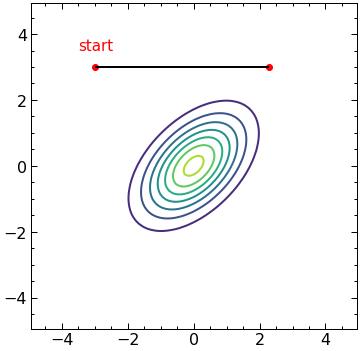

In [31]:
gibbs_sampling_demo(steps=1)

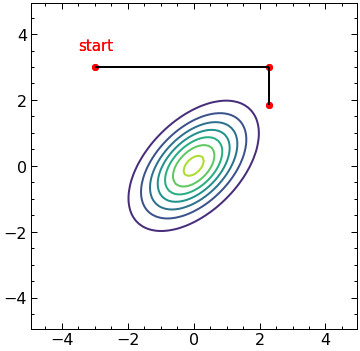

In [32]:
gibbs_sampling_demo(steps=2)

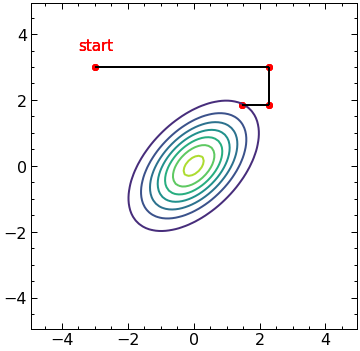

In [33]:
gibbs_sampling_demo(steps=3)

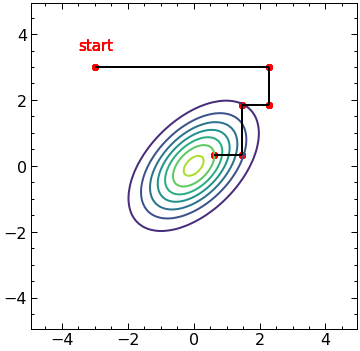

In [34]:
gibbs_sampling_demo(steps=5)

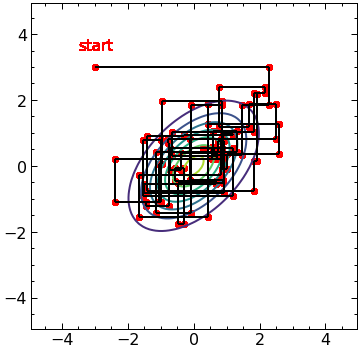

In [36]:
gibbs_sampling_demo(steps=100)

In [35]:

interact(gibbs_sampling_demo, steps=(1, 30))

interactive(children=(IntSlider(value=2, description='steps', max=30, min=1), Output()), _dom_classes=('widget…

<function __main__.gibbs_sampling_demo(steps=2)>

## Hybrid Monte Carlo 采样

Hybrid Monte Carlo （HMC）被广泛应用于 Lattice QCD ，抽取量子场的 configurations。

HMC 的基本思路是：

引入共轭动量场 $\pi$, 将配分函数从对场 $\phi$ 的泛函积分改写为对相空间 $\Phi\equiv(\phi, \pi)$ 的泛函积分，

\begin{align}
\mathcal{Z} = \int [d\phi] e^{-S(\phi)} = \int [d\Phi] e^{-H(\Phi)}, \quad\; H(\Phi) = {1\over 2}\pi^2 + S(\phi),
\end{align}

其中 $[d\Phi] = [d\phi d\pi]$。 

然后采用下列步骤，

1. 任意选取初始的场的 configuration
2. 使用 Gauss 分布生成 $\pi$, $P_G(\pi) \propto \exp(-\pi^2 / 2)$
3. 按转移概率 $P_H$ 对场 $\Phi$ 进行演化，（需要满足可逆条件）
\begin{align}
P_H(\Phi \rightarrow \Phi') = P_H(\Phi'_r \rightarrow \Phi_r), \quad\; \Phi_r \equiv (\phi, -\pi)
\end{align}
4. 按照 Hastings 概率接受新的 configuration $\Phi'$,
\begin{align}
\alpha = \min(1, e^{-\Delta H})
\end{align}

其中 $\Delta H = H(\Phi') - H(\Phi)$
5. 如果接受了 $\Phi'$, 再带着 $\phi$ 回到第2步；否则，保留原来的 $\phi$, 回到第二步。


第三步的转移概率一般使用分子动力学的方法，更新 $\phi$ 和 $\pi$,

\begin{align}
{d \over d s} \begin{bmatrix} \phi \\ \pi \end{bmatrix} = \begin{bmatrix} 0 & 1\\ -1 & 0 \end{bmatrix}\begin{bmatrix} \delta H/\delta \phi \\ \delta H/\delta \pi \end{bmatrix} = \begin{bmatrix} \pi \\ - \delta S(\phi)/\delta \phi \end{bmatrix}
\end{align}

上面这个方程就是运动方程写成辛矩阵乘积的形式。

可见 Hybrid Monte Carlo 是 MCMC 算法与决定性算法（分子动力学方法）的结合。

## 参考文献

IFrame("https://feng.li/files/statcomp/book/mcmc.html#%E9%A9%AC%E5%B0%94%E7%A7%91%E5%A4%AB%E9%93%BE", width=800, height=600)

IFrame("https://bookdown.org/rdpeng/advstatcomp/non-uniform-random-numbers.html", width=800, height=600)

IFrame("https://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf", width=800, height=600)

IFrame("https://www.math.pku.edu.cn/teachers/lidf/docs/statcomp/html/_statcompbook/rng-nonuni.html", width=800, height=600)

## 练习

使用 Metropolis Hastings 算法对下列混合正态分布函数抽样

\begin{align}
X \sim 0.3 \mathcal{N}(0, 1) + 0.7 \mathcal{N}(4, 1)
\end{align}

对比不同 proposal function 使用不同 $\sigma$ 时抽样结果。

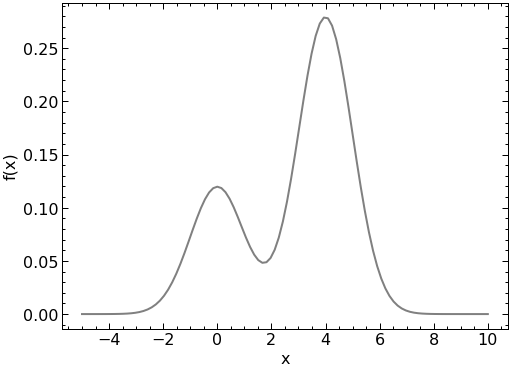

In [41]:
plot_hybrid_normal()